In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
spark = SparkSession.builder.appName('review').getOrCreate()

In [4]:
# Load data
pd_data = pd.read_excel("../../Data/Womens_Clothing_E_Commerce_Reviews.xlsx", sheet_name='Reviews', index_col=0)

In [5]:
pd_data.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
pd_data = pd_data.drop(columns=['Clothing ID', 'Title'])

In [7]:
pd_data = pd_data.dropna()

In [9]:
conditions = [(pd_data.Age <= 30), (pd_data.Age > 30) & (pd_data.Age <= 60), (pd_data.Age > 60)]
values = ['Young', 'MiddleAge', 'Elderly']

In [10]:
pd_data['Age_Group'] = np.select(conditions, values)

In [11]:
pd_data.head(5)

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age_Group
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,MiddleAge
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,MiddleAge
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,MiddleAge
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,MiddleAge
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,MiddleAge


<AxesSubplot:xlabel='Rating', ylabel='Count'>

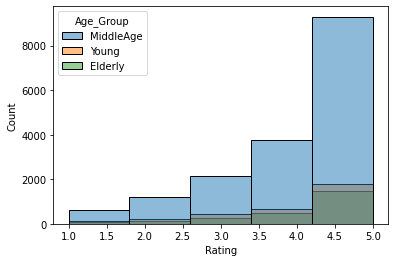

In [14]:
sns.histplot(data=pd_data, x='Rating', color='navy', bins=5, hue='Age_Group')

<AxesSubplot:xlabel='Age', ylabel='Count'>

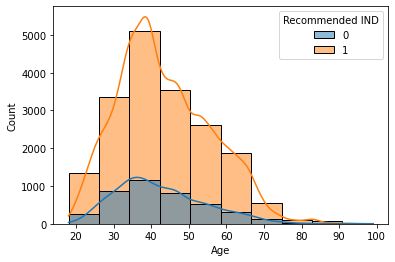

In [16]:
sns.histplot(data=pd_data, x='Age',color='navy', kde=True, bins=10, hue='Recommended IND')

In [10]:
data = spark.createDataFrame(pd_data)

In [11]:
data.show(5)

+--------------------+------+---------------+
|         Review Text|Rating|Recommended IND|
+--------------------+------+---------------+
|Absolutely wonder...|     4|              1|
|Love this dress! ...|     5|              1|
|I had such high h...|     3|              0|
|I love, love, lov...|     5|              1|
|This shirt is ver...|     5|              1|
+--------------------+------+---------------+
only showing top 5 rows



In [12]:
data = data.withColumn('length', length(data['Review Text']))

In [13]:
data.show(5)

+--------------------+------+---------------+------+
|         Review Text|Rating|Recommended IND|length|
+--------------------+------+---------------+------+
|Absolutely wonder...|     4|              1|    53|
|Love this dress! ...|     5|              1|   303|
|I had such high h...|     3|              0|   500|
|I love, love, lov...|     5|              1|   124|
|This shirt is ver...|     5|              1|   192|
+--------------------+------+---------------+------+
only showing top 5 rows



In [14]:
data.groupby('Rating').mean().show()

+------+-----------+--------------------+------------------+
|Rating|avg(Rating)|avg(Recommended IND)|       avg(length)|
+------+-----------+--------------------+------------------+
|     5|        5.0|  0.9981657229444134| 298.9145864901507|
|     1|        1.0|0.018292682926829267| 305.0365853658537|
|     3|        3.0|  0.4145995747696669| 328.4156626506024|
|     2|        2.0|0.060723514211886306|319.40374677002586|
|     4|        4.0|  0.9665783574485429|323.43386998165886|
+------+-----------+--------------------+------------------+



#### Độ dài review của từng loại ratings không chênh lệch đáng kể

In [15]:
data.groupby('Rating').count().show()

+------+-----+
|Rating|count|
+------+-----+
|     5|12539|
|     1|  820|
|     3| 2822|
|     2| 1548|
|     4| 4907|
+------+-----+



#### Rating 4-5* chiếm đa số => phần lớn các review là tích cực

In [16]:
rating_to_num = StringIndexer(inputCol='Rating', outputCol='label')
tokenizer = Tokenizer(inputCol='Review Text', outputCol='token_text')
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
clean_up = VectorAssembler(inputCols=['tf_idf', 'length', 'Recommended IND'], outputCol='features')

In [17]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up, rating_to_num])
clearer = data_prep_pipe.fit(data)
clean_data = clearer.transform(data)

In [18]:
clean_data = clean_data.select(['label', 'features'])

In [19]:
clean_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(38356,[22,51,140...|
|  0.0|(38356,[0,10,11,1...|
|  2.0|(38356,[1,5,6,8,1...|
|  0.0|(38356,[0,4,7,41,...|
|  0.0|(38356,[0,4,23,36...|
|  3.0|(38356,[0,1,4,14,...|
|  0.0|(38356,[2,3,8,11,...|
|  1.0|(38356,[6,8,10,14...|
|  0.0|(38356,[0,10,11,3...|
|  0.0|(38356,[0,1,4,5,9...|
+-----+--------------------+
only showing top 10 rows



In [20]:
(training, testing) = clean_data.randomSplit([0.7, 0.3])

### Naive Bayer

In [21]:
nb = NaiveBayes()

In [22]:
predictor_nb = nb.fit(training)
test_result_nb = predictor_nb.transform(testing)
test_result_nb.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   82|
|  1.0|       1.0|  544|
|  3.0|       2.0|  198|
|  4.0|       2.0|   90|
|  0.0|       1.0|  810|
|  0.0|       4.0|   80|
|  1.0|       0.0|  525|
|  2.0|       2.0|  338|
|  3.0|       1.0|   76|
|  2.0|       3.0|  167|
|  1.0|       4.0|   25|
|  4.0|       4.0|   40|
|  2.0|       4.0|   40|
|  3.0|       4.0|   49|
|  2.0|       1.0|  241|
|  1.0|       2.0|  294|
|  0.0|       0.0| 2558|
|  1.0|       3.0|   88|
|  4.0|       3.0|   88|
|  0.0|       2.0|  215|
+-----+----------+-----+
only showing top 20 rows



In [23]:
acc_eval = MulticlassClassificationEvaluator()

In [24]:
acc_nb = acc_eval.evaluate(test_result_nb)
print("Accuracy of Naive Bayer at predicting was: {}".format(acc_nb))

Accuracy of Naive Bayer at predicting was: 0.5435579286225068


### Logistic Regression

In [25]:
lg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [26]:
predictor_lg = lg.fit(training)
test_result_lg = predictor_lg.transform(testing)
test_result_lg.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  434|
|  1.0|       1.0|  292|
|  3.0|       2.0|  180|
|  4.0|       2.0|   90|
|  0.0|       1.0|  189|
|  1.0|       0.0| 1137|
|  2.0|       2.0|  200|
|  3.0|       1.0|   83|
|  2.0|       3.0|   28|
|  4.0|       4.0|    5|
|  2.0|       4.0|    3|
|  3.0|       4.0|    4|
|  2.0|       1.0|  203|
|  1.0|       2.0|   43|
|  0.0|       0.0| 3558|
|  1.0|       3.0|    4|
|  4.0|       3.0|   25|
|  0.0|       2.0|   11|
|  4.0|       0.0|  102|
|  3.0|       3.0|   29|
+-----+----------+-----+
only showing top 20 rows



In [27]:
acc_lg = acc_eval.evaluate(test_result_lg)
print("Accuracy of Logistic Regression model at predicting was: {}".format(acc_lg))

Accuracy of Logistic Regression model at predicting was: 0.5262167409666229


### Random Forest

In [28]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500, maxDepth=5, maxBins=64)

In [29]:
predictor_rf = lg.fit(training)
test_result_rf = predictor_rf.transform(testing)
test_result_rf.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  434|
|  1.0|       1.0|  292|
|  3.0|       2.0|  180|
|  4.0|       2.0|   90|
|  0.0|       1.0|  189|
|  1.0|       0.0| 1137|
|  2.0|       2.0|  200|
|  3.0|       1.0|   83|
|  2.0|       3.0|   28|
|  4.0|       4.0|    5|
|  2.0|       4.0|    3|
|  3.0|       4.0|    4|
|  2.0|       1.0|  203|
|  1.0|       2.0|   43|
|  0.0|       0.0| 3558|
|  1.0|       3.0|    4|
|  4.0|       3.0|   25|
|  0.0|       2.0|   11|
|  4.0|       0.0|  102|
|  3.0|       3.0|   29|
+-----+----------+-----+
only showing top 20 rows



In [30]:
acc_rf = acc_eval.evaluate(test_result_rf)
print("Accuracy of model at predicting was: {}".format(acc_rf))

Accuracy of model at predicting was: 0.5262167409666229
